In [21]:
import rowan
import numpy as np
import matplotlib.pyplot as plt
import LMCE.cfusdlog as cfusdlog

t2t = 0.006         # thrust-to-torque ratio
g2N = 0.00981
GRAVITY = 9.81      # m / s^2
ARM_LENGTH = 0.046  # m

In [22]:
def residual(data_usd: dict,
             is_brushless: bool = False,
             use_rpm: bool = True,
             force_per_rotor: bool=False,
             world_acc: bool=False):

    # Set mass
    if is_brushless:
        total_mass = .0444
    else:
        total_mass = .0347
    
    q = rowan.from_euler(data_usd["ctrlLee.rpyx"],
                         data_usd["ctrlLee.rpyy"],
                         data_usd["ctrlLee.rpyz"])

    # Get acceleration in world frame
    if not world_acc:
        
        acc_body = np.array([
            data_usd['ctrlLee.a_imux'],
            data_usd['ctrlLee.a_imuy'],
            data_usd['ctrlLee.a_imuz']]).T

        acc_world = rowan.rotate(q, acc_body)

    else:
        acc_world = np.array([
            data_usd['stateEstimate.ax'],
            data_usd['stateEstimate.ay'],
            data_usd['stateEstimate.az']]).T

    acc_world *= 9.81

    # Get total forces
    if use_rpm:
        rpm = np.array([
            data_usd['rpm.m1'],
            data_usd['rpm.m2'],
            data_usd['rpm.m3'],
            data_usd['rpm.m4']]).T
        if is_brushless:
            force_in_grams = 4.310657321921365e-08 * rpm**2
        else:
            if force_per_rotor:
                force = rpm**2 * np.array([2.0938753372837369e-10,
                                           2.2766702598220073e-10,
                                           1.906494181367591e-10,
                                           2.4578364131636854e-10])
            else:
                force_in_grams = 2.40375893e-08 * rpm**2 + - \
                    3.74657423e-05 * rpm + -7.96100617e-02

    else:  # pwm
        pwm = np.array([
            data_usd['pwm.m1_pwm'],
            data_usd['pwm.m2_pwm'],
            data_usd['pwm.m3_pwm'],
            data_usd['pwm.m4_pwm']]).T
        if is_brushless:
            force_in_grams = -5.360718677769569 + pwm * 0.0005492858445116151
        else:
            force_in_grams = 1.65049399e-09 * pwm**2 + \
                9.44396129e-05 * pwm + -3.77748052e-01

    if not force_per_rotor:
        force = force_in_grams * g2N

    eta = np.empty((force.shape[0], 4))
    f_u = np.empty((force.shape[0], 3))

    # Get residual forces
    arm = 0.707106781 * ARM_LENGTH
    B0 = np.array([
        [1, 1, 1, 1],
        [-arm, -arm, arm, arm],
        [-arm, arm, arm, -arm],
        [-t2t, t2t, -t2t, t2t]
    ])

    for k in range(force.shape[0]):
        eta[k] = np.dot(B0, force[k])
        f_u[k] = np.array([0, 0, eta[k, 0]])

    f_a = total_mass * acc_world - rowan.rotate(q, f_u)
    
    tau_a = np.zeros(f_a.shape)
    tau_a[:, 0] = data_usd["ctrlLee.tau_rpm_fx"] - data_usd["ctrlLee.tau_gyro_fx"]
    tau_a[:, 1] = data_usd["ctrlLee.tau_rpm_fy"] - data_usd["ctrlLee.tau_gyro_fy"]
    tau_a[:, 2] = data_usd["ctrlLee.tau_rpm_fz"] - data_usd["ctrlLee.tau_gyro_fz"]

    return f_a, tau_a

In [23]:
data_usd = cfusdlog.decode("./eckart_new_lee_no_indi_flights/tle82")
data = data_usd['fixedFrequency']
for k in data.keys():
    print(k)

timestamp
stateEstimate.x
stateEstimate.y
stateEstimate.z
ctrltarget.x
ctrltarget.y
ctrltarget.z
stateEstimate.vx
stateEstimate.vy
stateEstimate.vz
stateEstimate.ax
stateEstimate.ay
stateEstimate.az
ctrltarget.vx
ctrltarget.vy
ctrltarget.vz
ctrlLee.rpyx
ctrlLee.rpyy
ctrlLee.rpyz
ctrlLee.rpydx
ctrlLee.rpydy
ctrlLee.rpydz
ctrlLee.omegax
ctrlLee.omegay
ctrlLee.omegaz
ctrlLee.omegarx
ctrlLee.omegary
ctrlLee.omegarz
ctrlLee.a_rpmx
ctrlLee.a_rpmy
ctrlLee.a_rpmz
ctrlLee.a_rpm_fx
ctrlLee.a_rpm_fy
ctrlLee.a_rpm_fz
ctrlLee.a_imux
ctrlLee.a_imuy
ctrlLee.a_imuz
ctrlLee.a_imu_fx
ctrlLee.a_imu_fy
ctrlLee.a_imu_fz
ctrlLee.tau_rpmx
ctrlLee.tau_rpmy
ctrlLee.tau_rpmz
ctrlLee.tau_rpm_fx
ctrlLee.tau_rpm_fy
ctrlLee.tau_rpm_fz
ctrlLee.tau_gyro_x
ctrlLee.tau_gyro_y
ctrlLee.tau_gyro_z
ctrlLee.tau_gyro_fx
ctrlLee.tau_gyro_fy
ctrlLee.tau_gyro_fz
rpm.m1
rpm.m2
rpm.m3
rpm.m4
motor.m1
motor.m2
motor.m3
motor.m4
pm.vbatMV


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

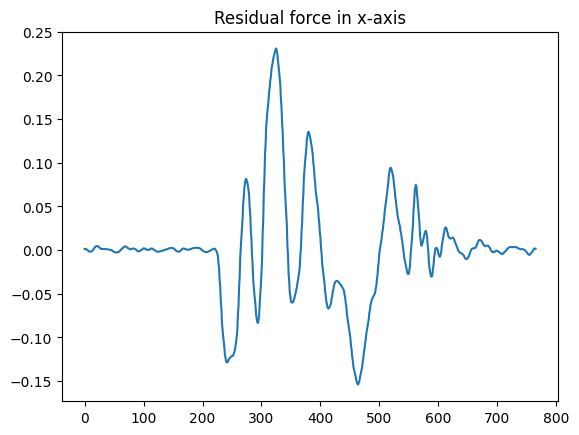

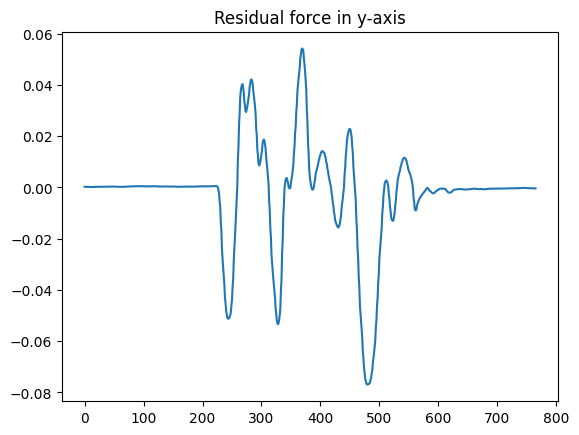

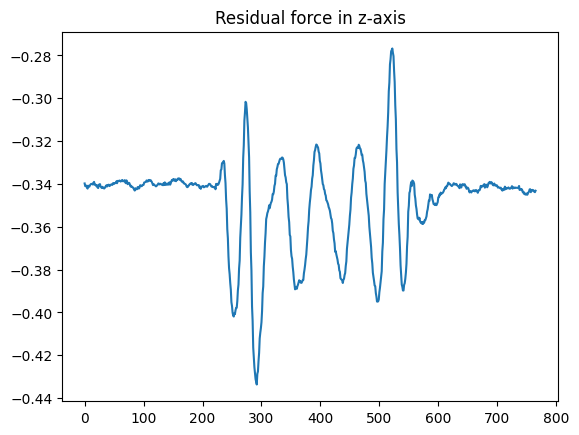

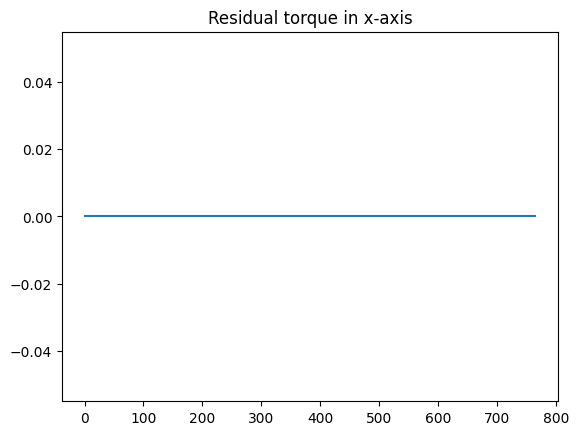

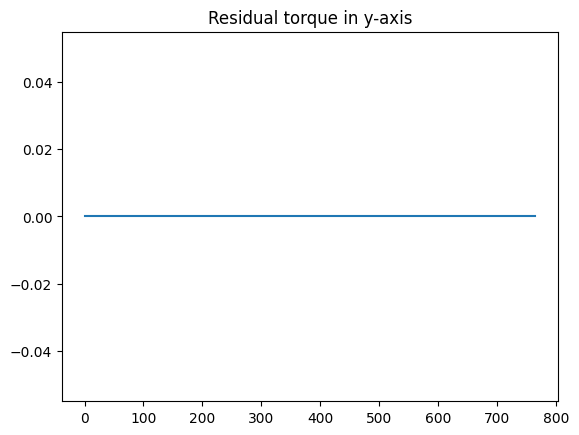

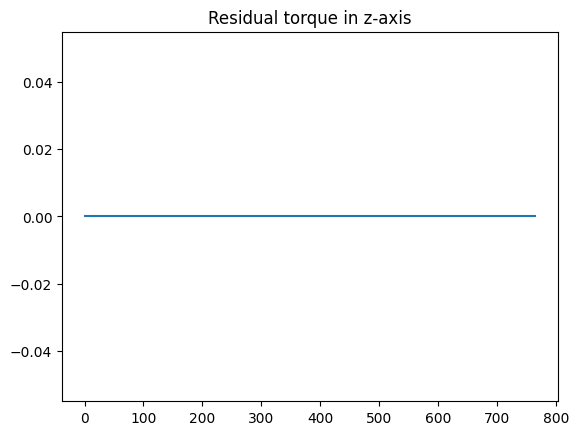

In [24]:
f_a, tau_a = residual(data, use_rpm=True)
residual_func = lambda data: residual(data)

X_train, y_train = prepare_data(training_data_paths, save_as="train_data", residual_func=residual_func, overwrite=True)
X_test, y_test = prepare_data(testing_data_paths, save_as="test_data", shuffle_data=False, residual_func=residual_func, overwrite=True)

for i, f in enumerate(["Force", "Torque"]):
    for j, v in enumerate(["X", "Y", "Z"]):
        idx = j+i*3
        ax[idx].plot(y_test[:, idx], label="Real")
        # ax[idx].plot(pred[:, idx], label="Predicted")
        ax[idx].set_title(f'{f} {v}')
        ax[idx].set_xlabel('Timestamp')
        ax[idx].set_ylabel(f'{f} prediction')
        ax[idx].legend()